In [147]:
from copy import copy
import os
import shutil
import matplotlib.colors as colors
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import cost_function
from database import CityLearnDatabase, SQLiteDatabase

In [145]:
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

# Reward Function Design
***
$E$ is an array of the district buildings' electricity demand, $n$ is the number of buildings in the district and $t$ is the current timestep.

1. __Default__
    $$
    r(t)^\textrm{def} = E(t)
    $$

2. __MARLISA__
    $$
    r(t)^\textrm{marl} = \textrm{sign}\left(r(t)^\textrm{def}\right) \times 0.01 \times \left|{r(t)^\textrm{def}}\right|^2 \times \textrm{max}\left(0, -\sum_{i=1}^{n-1}{r(t)^\textrm{def}_i}\right)
    $$

3. __SAC__
    $$
    r(t)^\textrm{sac} = \left[\textrm{min}\left(0,{r(t)_0^\textrm{def}}^3\right), \dots, \textrm{min}\left(0,{r(t)_{n-1}^\textrm{def}}^3\right)\right]
    $$

4. __Ramping Square__
    $$
    r(t)^\textrm{ramp} = \left[-\left(\left(\sum_{i=0}^{n-1}{r(t)^\textrm{def}_i} - \sum_{i=0}^{n-1}{r(t-1)^\textrm{def}_i}\right)^2\right)_0, \dots, -\left(\left(\sum_{i=0}^{n-1}{r(t)^\textrm{def}_i} - \sum_{i=0}^{n-1}{r(t-1)^\textrm{def}_i}\right)^2\right)_{n-1}\right] \div n
    $$

5. __Exponential__
    $$
    r(t)^\textrm{exp} = \left[\left(-e^{0.0002 \times \sum_{i=0}^{n-1}{-r(t)^\textrm{def}_i}}\right)_0, \dots, \left(-e^{0.0002 \times \sum_{i=0}^{n-1}{-r(t)^\textrm{def}_i}}\right)_{n-1}\right] \div n
    $$

    Where 0.0002 is a scaling factor to avoid high exponents defined as $\frac{\lambda}{50}$. We use $\lambda = 0.01$.

6. __Mixed__
    $$
    r(t)^\textrm{mix} = r(t)^\textrm{ramp} + r(t)^\textrm{exp}
    $$

# Simulation Analysis
***

### C8 
- training off-line from the fixed logs of an external behavior policy.The benchmark here is to learn a control law  from data generated by a sub-optimal reference controller, .e.g., a rule based controller, which is often available, essentially a system log. In addition to the control environment, datasets of various size, e.g.,two weeks, one months, 6 months should be provided that are generated with a known reference rule based controller. Then, the controllers can be evaluated on the ability to improve these baselines.

In [25]:
c8_simulation_output_directory = 'simulation_output_c8'
c8_database_filepath = os.path.join(c8_simulation_output_directory,'simulation.db')
grid_search_filepath = 'grid_search_c8.csv'
source_filepaths = [os.path.join(c8_simulation_output_directory,f'simulation_{i}.db') for i in range(1,30)]
CityLearnDatabase.concatenate(c8_database_filepath,source_filepaths)
database = SQLiteDatabase(c8_database_filepath)

Database: 29/29, Table: 22/22

In [24]:
def update_schema(source_filepaths,grid_search_filepath):
    temp_filepath = 'temp.db'

    try:
        for i, filepath in enumerate(source_filepaths):
            print(f'{i+1}/{len(source_filepaths)}')
            temp_database = CityLearnDatabase(temp_filepath,None,None,overwrite=True,apply_changes=True)
            existing_database = CityLearnDatabase(filepath,None,None,overwrite=False,apply_changes=False)
            table_names = temp_database.query_table("""
            SELECT 
                name
            FROM 
                sqlite_master
            WHERE 
                type = 'table' AND 
                name NOT LIKE 'sqlite_%'
            """)['name'].tolist()
            
            for table_name in table_names:
                data = existing_database.get_table(table_name)

                if table_name == 'timestep' and 'environment_id' not in data.columns:
                    environment_id = existing_database.get_table('environment').iloc[0]['id']
                    data['environment_id'] = environment_id
                else:
                    pass

                if table_name == 'agent':
                    continue
                else:
                    pass

                if table_name == 'building':
                    agent_data = existing_database.get_table('agent')
                    
                    if  'basic_rbc' not in agent_data.columns:
                        agent_id_data = data[['agent_id','environment_id']].copy()
                        agent_id_data = agent_id_data.rename(columns={'agent_id':'id'})
                        environment_data = temp_database.get_table('environment')[['id','simulation_id']].copy()
                        environment_data = environment_data.rename(columns={'id':'environment_id'})
                        simulation_data = temp_database.get_table('simulation')[['id','name']].copy()
                        simulation_data.columns = ['simulation_id','simulation_name']
                        grid_search = pd.read_csv(grid_search_filepath)[['--simulation_id','--basic_rbc']].copy()
                        grid_search.columns = ['simulation_id','basic_rbc']
                        agent_data = pd.merge(agent_data,agent_id_data,on='id',how='left')
                        agent_data = pd.merge(agent_data,environment_data,on='environment_id',how='left')
                        agent_data = pd.merge(agent_data,simulation_data,on='simulation_id',how='left')
                        agent_data = agent_data.drop(columns=['simulation_id'])
                        agent_data = agent_data.rename(columns={'simulation_name':'simulation_id'})
                        agent_data = pd.merge(agent_data,grid_search,on='simulation_id',how='left')
                        agent_data = agent_data[temp_database.get_table('agent').columns.tolist()].copy()
                        temp_database.insert('agent',agent_data.columns.tolist(),agent_data.values)
                        
                    else:
                        pass
                else:
                    pass

                temp_database.insert(table_name,data.columns.tolist(),data.values)

                if table_name == 'building':
                    break
                else:
                    continue

            shutil.copy(temp_filepath,filepath)

    finally:
        os.remove(temp_filepath)

1/1


In [28]:
# offline training periods
metadata = database.query_table("""
SELECT
    s.id AS simulation_id,
    s.name AS simulation_name,
    e.id AS environment_id,
    a.name AS agent_name,
    a.seed AS seed,
    AVG(a.exploration_period) AS exploration_period
FROM agent a
LEFT JOIN building b ON b.agent_id = a.id
LEFT JOIN environment e ON e.id = b.environment_id
LEFT JOIN simulation s ON s.id = e.simulation_id
GROUP BY
    s.id,
    e.id,
    a.name
""")

grid_search = pd.read_csv(grid_search_filepath)[['--simulation_id','--basic_rbc']].copy()
grid_search.columns = ['simulation_name','basic_rbc']
metadata = pd.merge(metadata,grid_search,on='simulation_name',how='left')
group_list = []

for i, (name, group) in enumerate(metadata.groupby(['agent_name','basic_rbc','exploration_period'])):
    group = group.copy()
    group.loc[:,'simulation_set'] = i
    group_list.append(group)

metadata = pd.concat(group_list,ignore_index=True)

print('Simulation metadata')
display(metadata)
exploration_periods = database.query_table("SELECT DISTINCT exploration_period FROM agent")['exploration_period'].tolist()
agent_names = database.query_table("SELECT DISTINCT name FROM agent")['name'].tolist()

Simulation metadata


,simulation_id,simulation_name,environment_id,agent_name,seed,exploration_period,basic_rbc,simulation_set
0,28,simulation_28,28,basic_rbc,0,0.0,True,0.0
1,14,simulation_14,14,marlisa,0,744.0,False,1.0
2,16,simulation_16,16,marlisa,1,744.0,False,1.0
3,18,simulation_18,18,marlisa,2,744.0,False,1.0
4,8,simulation_8,8,marlisa,0,4344.0,False,2.0
5,10,simulation_10,10,marlisa,1,4344.0,False,2.0
6,12,simulation_12,12,marlisa,2,4344.0,False,2.0
7,2,simulation_2,2,marlisa,0,8760.0,False,3.0
8,4,simulation_4,4,marlisa,1,8760.0,False,3.0
9,6,simulation_6,6,marlisa,2,8760.0,False,3.0


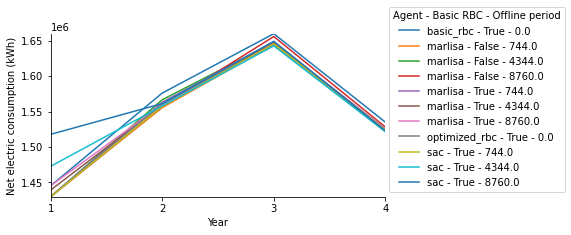

In [43]:
# environment level net electricity consumption
# plot_metadata = metadata[metadata['agent_name']=='marlisa'].copy()

fig, ax = plt.subplots(1,1,figsize=(6,3))

for (simulation_set, exploration_period, agent_name, basic_rbc), group in metadata.groupby(['simulation_set','exploration_period','agent_name', 'basic_rbc']):
    environment_ids = tuple(group['environment_id'].tolist())
    query = f"""
    SELECT
        CAST (timestep / 8760 AS INTEGER) + 1 AS year,
        SUM(value) AS value
    FROM (
        SELECT
            t.timestep,
            AVG(e.net_electric_consumption) AS value
        FROM environment_timeseries e
        LEFT JOIN timestep t ON t.id = e.timestep_id
        WHERE e.environment_id IN {environment_ids}
        GROUP BY
            t.timestep
    )
    GROUP BY
        CAST (timestep / 8760 AS INTEGER) + 1
    """
    plot_data = database.query_table(query)
    x = plot_data['year']
    y = plot_data['value']
    ax.plot(x,y,label=f'{agent_name} - {basic_rbc} - {exploration_period}')
    ax.set_xticks(range(int(min(x)),int(max(x)+1)))
    ax.set_xlabel('Year')
    ax.set_ylabel('Net electric consumption (kWh)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

ax.legend(title='Agent - Basic RBC - Offline period',loc=4,bbox_to_anchor=(1.55,0))
ax.margins(0)
plt.show()

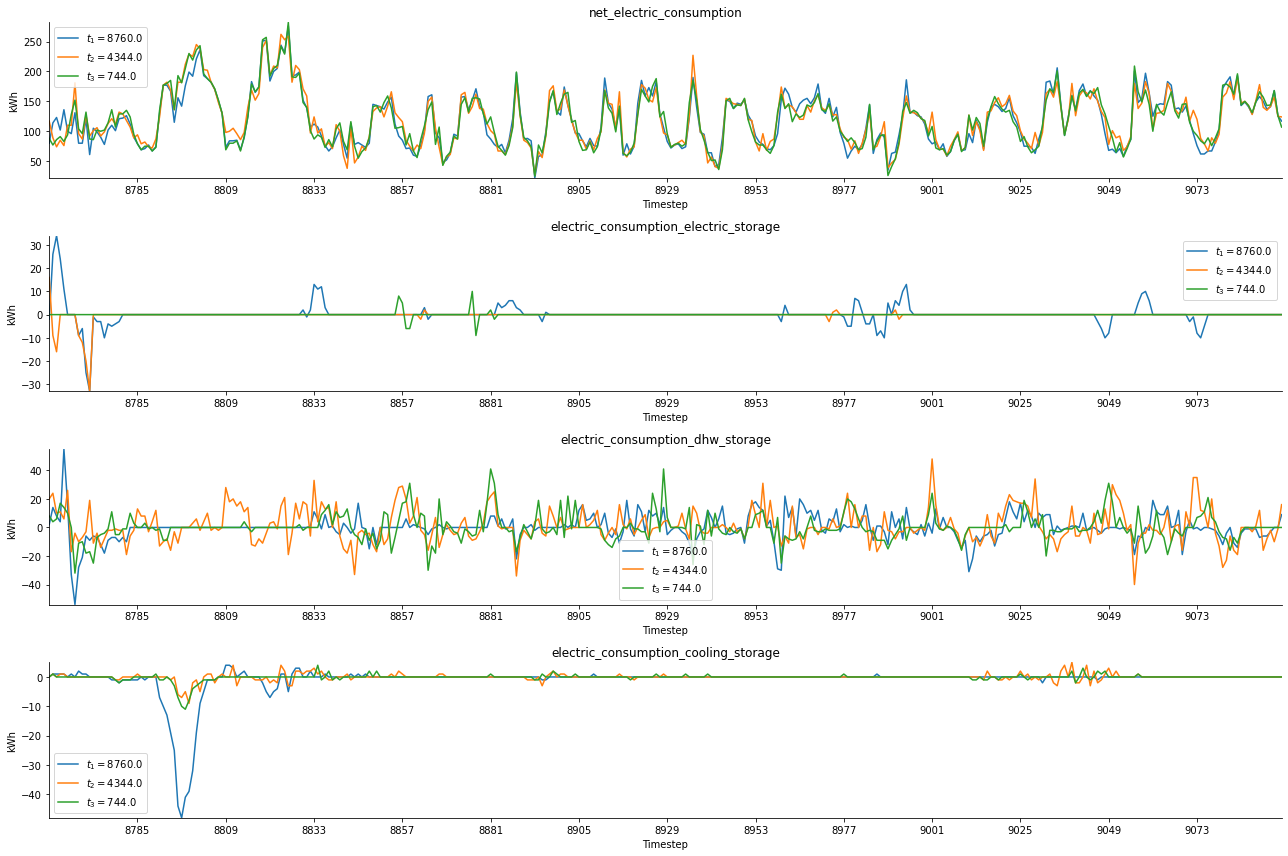

In [56]:
# environment cooling storage, dhw storage and electrical storage electrical charge and discharge power timeseries
columns = ['net_electric_consumption','electric_consumption_electric_storage','electric_consumption_dhw_storage','electric_consumption_cooling_storage']
fig, axs = plt.subplots(len(columns),1,figsize=(18,3*len(columns)))
plot_week_count = 2
daily_timesteps = 24
weekly_timesteps = 24*7
start_timestep = 8760
end_timestep = start_timestep + weekly_timesteps*plot_week_count
plot_period = (start_timestep,end_timestep)
exploration_timesteps_to_show = 0
plot_metadata = metadata[metadata['agent_name']=='marlisa']


for ax, column in zip(fig.axes, columns):
    for _, environment_id, _, exploration_period in plot_metadata.to_records(index=False):
        query = f"""
        SELECT
            t.timestep,
            e.{column} AS value
        FROM environment_timeseries e
        LEFT JOIN timestep t ON t.id = e.timestep_id
        WHERE e.environment_id = {environment_id}
        """
        plot_data = database.query_table(query).iloc[plot_period[0]:plot_period[1]+exploration_timesteps_to_show]
        x = plot_data['timestep']
        y = plot_data['value']
        ax.plot(x,y,label=rf'$t_{environment_id}={exploration_period}$')
    
    ax.xaxis.set_major_locator(ticker.IndexLocator(base=24,offset=24))
    ax.set_title(column)
    ax.legend()
    ax.set_xlabel('Timestep')
    ax.set_ylabel('kWh')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()


In [239]:
# # cost functions
# plot_data_list = []

# for i, ((simulation_set, exploration_period, agent_name, basic_rbc), group) in enumerate(metadata.groupby(['simulation_set','exploration_period','agent_name', 'basic_rbc'])):
#     print(f'\r{i+1}/{len(metadata["simulation_set"].unique())}',end='')
#     environment_ids = tuple(group['environment_id'].tolist())
#     query = query = f"""
#     SELECT
#         t.timestep,
#         AVG(e.net_electric_consumption) AS net_electric_consumption
#     FROM environment_timeseries e
#     LEFT JOIN timestep t ON t.id = e.timestep_id
#     WHERE e.environment_id IN {environment_ids}
#     GROUP BY
#         t.timestep
#     """
#     plot_data = database.query_table(query)
    
    # cost functions
    # plot_data['ramping_cost_function'] = plot_data['net_electric_consumption'].rolling(
    #     window=plot_data.shape[0],min_periods=2
    # ).apply(lambda x: cost_function.ramping(x),raw=True)
    # plot_data['load_factor_cost_function'] = plot_data['net_electric_consumption'].rolling(
    #     window=plot_data.shape[0],min_periods=730
    # ).apply(lambda x: cost_function.load_factor(x),raw=True)
    # plot_data['average_daily_peak_cost_function'] = plot_data['net_electric_consumption'].rolling(
    #     window=plot_data.shape[0],min_periods=24
    # ).apply(lambda x: cost_function.average_daily_peak(x),raw=True)
    # plot_data['annual_peak_demand_cost_function'] = plot_data['net_electric_consumption'].rolling(
    #     window=plot_data.shape[0],min_periods=8760
    # ).apply(lambda x: cost_function.net_electric_consumption(x),raw=True)
    # plot_data['net_electric_consumption_cost_function'] = plot_data['net_electric_consumption'].rolling(
    #     window=plot_data.shape[0],min_periods=1
    # ).apply(lambda x: cost_function.net_electric_consumption(x),raw=True)
    # plot_data['agent_name'] = agent_name
    # plot_data['exploration_period'] = exploration_period
    # plot_data['basic_rbc'] = basic_rbc
    # plot_data['simulation_set'] = simulation_set
    # plot_data_list.append(plot_data)

# calculate normalized cost
# plot_data = pd.concat(plot_data_list,ignore_index=True)
# plot_data = pd.to_pickle('simulation_c8_cost_function.pkl')
plot_data = pd.read_pickle('simulation_c8_cost_function.pkl')
plot_data = plot_data.drop(columns=['net_electric_consumption'])
cost_function_columns = [c for c in plot_data.columns if c.endswith('cost_function')]
id_vars = [c for c in plot_data.columns if c not in cost_function_columns]
plot_data = plot_data.melt(id_vars=id_vars,value_vars=cost_function_columns)
plot_data['variable'] += '_norm'
rbc_data = plot_data[plot_data['agent_name'].isin(['basic_rbc','optimized_rbc'])].copy()
rbc_data = rbc_data.rename(columns={'value':'baseline_value','agent_name':'baseline_controller'})
rbc_data = rbc_data[['timestep','variable','baseline_value','baseline_controller']].copy()
plot_data = plot_data.drop(rbc_data.index)
plot_data = pd.merge(plot_data,rbc_data,on=['timestep','variable'],how='left')
plot_data['norm_value'] = plot_data['value']/plot_data['baseline_value']

# get rolling average
plot_data_list = []

for (simulation_set, baseline_controller, variable), group in plot_data.groupby(['simulation_set','baseline_controller','variable']):
    group = group.sort_values('timestep')

    if variable == 'annual_peak_demand':
        window = 365
    else:
        window = 30
    
    group['norm_value'] = group['norm_value'].rolling(window=window,min_periods=window).mean()
    plot_data_list.append(group)

plot_data = pd.concat(plot_data_list,ignore_index=True)

# plot normalized cost functions
column_count = plot_data.groupby(['agent_name','basic_rbc','baseline_controller']).size().shape[0]
row_count = len(cost_function_columns)
figsize = (3*column_count,2.2*row_count)
fig, axs = plt.subplots(row_count,column_count,figsize=figsize,sharey='row',sharex=True)

for i, ((agent_name, basic_rbc, baseline_controller), group) in enumerate(plot_data.groupby(['agent_name','basic_rbc','baseline_controller'])):
    for j, (variable, var_group) in enumerate(group.groupby(['variable'])):
        for exploration_period, env_group in var_group.groupby(['exploration_period']):
            x, y = env_group['timestep'], env_group['norm_value']
            axs[j,i].plot(x,y,label=int(exploration_period))

        baseline_controller_text = r'$\mathrm{RBC_{Basic}}$' if baseline_controller == 'basic_rbc' else r'$\mathrm{RBC_{Optimized}}$'
        axs[j,i].axhline(1,color='red',linestyle='--',)
        axs[j,i].legend(title='Offline period')
        axs[j,i].spines['top'].set_visible(False)
        axs[j,i].spines['right'].set_visible(False)
        axs[j,i].xaxis.set_major_locator(ticker.MultipleLocator(8760))

        if i == 0:
            axs[j,i].set_ylabel(variable.replace('_cost_function_norm','').replace('_',' ').capitalize())
        else:
            axs[j,i].set_ylabel(None)

        if j == 0:
            if agent_name == 'marlisa':
                agent_name_text = r'$\mathrm{MARLISA_{RBC_{Basic}}}$' if basic_rbc else r'$\mathrm{MARLISA_{RBC_{Optimized}}}$'
            elif agent_name == 'sac':
                agent_name_text = agent_name.upper()

            agent_name_text = f'{agent_name_text}/{baseline_controller_text}'
            axs[j,i].set_title(f'{agent_name_text}',fontsize=10)

        else:
            axs[j,i].set_title(None)

        if j == row_count - 1:
            axs[j,i].set_xlabel('Timestep')
        else:
            axs[j,i].set_xlabel(None)

        if i == 0 and j == 0:
            axs[j,i].legend(title='Offline period',bbox_to_anchor=(0.5,0.09),loc='upper center',bbox_transform=fig.transFigure,framealpha=0,ncol=5)
        else:
            axs[j,i].legend().set_visible(False)

# plt.tight_layout()
fig.align_ylabels()
plt.savefig('figures/c8_normalized_cost_function.pdf',bbox_inches='tight',transparent=True)
plt.close()

In [173]:
end_timestep = database.query_table('SELECT MAX(timestep) FROM timestep').iloc[0,0]
start_timestep = end_timestep - 8758
storage_timeseries_tables = ['cooling_storage_timeseries','dhw_storage_timeseries','electrical_storage_timeseries']
storage_tables = ['cooling_storage','dhw_storage','electrical_storage']
plot_metadata = metadata[metadata['agent_name'].isin(['marlisa','sac'])].copy()
row_count = len(plot_metadata['simulation_set'].unique())
column_count = 1
figsize=(18,row_count*4)
shading = 'nearest'

for storage_table, storage_timeseries_table in zip(storage_tables,storage_timeseries_tables):
    fig, axs = plt.subplots(row_count,column_count,figsize=figsize)
    for ax, ((simulation_set, agent_name, basic_rbc, exploration_period), group) in zip(fig.axes, plot_metadata.groupby(['simulation_set','agent_name','basic_rbc','exploration_period'])):
        environment_ids = tuple(group['environment_id'].tolist())
        query = f"""
        SELECT
            timestep,
            day,
            hour,
            AVG(soc) AS soc
        FROM (
            SELECT
                t.timestep,
                CAST (t.timestep/24 AS TYPE INTEGER) + 1 AS day,
                t.timestep - CAST (t.timestep/24 AS TYPE INTEGER)*24 AS hour,
                st.soc/sm.capacity AS soc
            FROM {storage_timeseries_table} st
            LEFT JOIN timestep t ON t.id = st.timestep_id
            LEFT JOIN {storage_table} sm ON sm.id = st.{storage_table}_id
            LEFT JOIN building b ON b.id = sm.building_id
            LEFT JOIN environment e ON e.id = b.environment_id
            WHERE t.timestep BETWEEN {start_timestep} AND {end_timestep}
            AND e.id IN {environment_ids}
        )
        GROUP BY
            day,
            hour,
            timestep
        """
        plot_data = database.query_table(query)
        plot_data = plot_data.pivot(index='hour',columns='day',values='soc')
        x, y, z = plot_data.columns.tolist(), plot_data.index.tolist(), plot_data.values
        divnorm = colors.TwoSlopeNorm(vcenter=0)
        cmap = copy(cm.get_cmap('Blues'))
        cmap.set_bad(color='grey')
        pcm = ax.pcolormesh(x,y,z,shading=shading,cmap=cmap,norm=divnorm)
        ax.set_xlabel('Day')
        ax.set_ylabel('Hour')
        agent_name = agent_name if agent_name != 'marlisa' else ('basic_rbc + marlisa' if basic_rbc else 'optimized_rbc + marlisa')
        ax.set_title(f'{agent_name} - {exploration_period}')
        cb = fig.colorbar(pcm,ax=ax,fraction=0.1,pad=0.02,label='SOC')
    
    fig.suptitle(f'{storage_table}',y=1.0,fontsize=16)
    plt.tight_layout()
    plt.savefig(f'figures/{storage_table}_soc_last_year.png',bbox_inches='tight',facecolor='white')
    plt.close()

In [193]:
# average weekly SOC for different seasons in last year
end_timestep = database.query_table('SELECT MAX(timestep) FROM timestep').iloc[0,0]
start_timestep = end_timestep - 8760
seasons = {
    'spring':(3,4,5),
    'summer':(6,7,8),
    'fall':(9,10,11),
    'winter':(12,1,2),
}
storage_timeseries_tables = ['cooling_storage_timeseries','dhw_storage_timeseries','electrical_storage_timeseries']
storage_tables = ['cooling_storage','dhw_storage','electrical_storage']
plot_metadata = metadata[metadata['agent_name'].isin(['marlisa','sac'])].copy()
row_count = len(plot_metadata['simulation_set'].unique())/len(plot_metadata['exploration_period'].unique())
row_count = int(row_count)
column_count = len(seasons)
figsize = (4*column_count,2.5*row_count)

for storage_table, storage_timeseries_table in zip(storage_tables,storage_timeseries_tables):
    fig, axs = plt.subplots(row_count,column_count,figsize=figsize,sharey=False,sharex=True)

    for i, season in enumerate(seasons):
        for j, ((agent_name, basic_rbc), agent_group) in enumerate(plot_metadata.groupby(['agent_name','basic_rbc'])):
            for exploration_period, group in agent_group.groupby(['exploration_period']):
                environment_ids = tuple(group['environment_id'].tolist())
                query = f"""
                SELECT
                    (t.day_type - 1)*24 + t.hour AS timestep,
                    t.day_type,
                    t.hour,
                    AVG(st.soc/sm.capacity) AS soc
                FROM {storage_timeseries_table} st
                LEFT JOIN timestep t ON t.id = st.timestep_id
                LEFT JOIN {storage_table} sm ON sm.id = st.{storage_table}_id
                LEFT JOIN building b ON b.id = sm.building_id
                LEFT JOIN environment e ON e.id = b.environment_id
                WHERE t.timestep BETWEEN {start_timestep} AND {end_timestep}
                AND e.id IN {environment_ids}
                AND t.month IN {seasons[season]}
                GROUP BY
                    t.day_type,
                    t.hour,
                    (t.day_type - 1)*24 + t.hour
                """
                plot_data = database.query_table(query)
                x, y = plot_data['timestep'], plot_data['soc']
                axs[j,i].plot(x,y,label=f'{exploration_period}')

            axs[j,i].legend(
                ncol=len(plot_metadata['exploration_period'].unique()),
                bbox_to_anchor=(0.5,-0.08),loc='upper center',framealpha=0,
            )
            temp_agent_name = agent_name if agent_name != 'marlisa' else ('basic_rbc + marlisa' if basic_rbc else 'optimized_rbc + marlisa')
            axs[j,i].set_title(f'{season}, {temp_agent_name}')
            axs[j,i].xaxis.set_major_locator(ticker.IndexLocator(base=24,offset=24))
            axs[j,i].spines['top'].set_visible(False)
            axs[j,i].spines['right'].set_visible(False)
            
    fig.suptitle(storage_table,fontsize=16,y=0.98)
    plt.tight_layout()
    plt.savefig(f'figures/{storage_table}_soc_weekly_average.png',bbox_inches='tight',facecolor='white')
    plt.close()

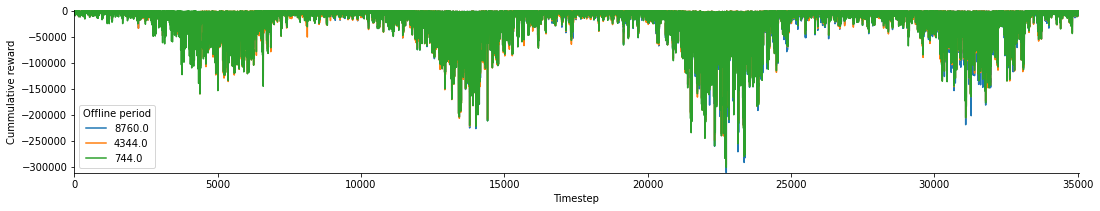

In [31]:
# cummulative reward timeseries
plot_metadata = metadata[metadata['agent_name']=='marlisa']
fig, ax = plt.subplots(1,1,figsize=(18,3))

for _, environment_id, _, exploration_period in plot_metadata.to_records(index=False):
    query = f"""
    SELECT
        t.timestep,
        SUM(r.value) AS value
    FROM reward_timeseries r
    LEFT JOIN timestep t ON t.id = r.timestep_id
    WHERE t.environment_id = {environment_id}
    GROUP BY
        t.timestep
    """
    plot_data = database.query_table(query)
    x = plot_data['timestep']
    y = plot_data['value']
    ax.plot(x,y,label=exploration_period)
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Cummulative reward')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

ax.legend(title='Offline period')
ax.margins(0)
plt.show()
    

In [114]:
query = """
SELECT
    b.id,
    0 AS "Cooling Storage (h)",
    0 AS "DHW Storage (h)",
    e.capacity AS "Electrical Storage (kW)",
    b.solar_power_installed AS "PV (kW)"
FROM building b
LEFT JOIN cooling_storage c ON c.building_id = b.id
LEFT JOIN dhw_storage d ON d.building_id = b.id
LEFT JOIN electrical_storage e ON e.building_id = b.id
WHERE environment_id = 1
"""
data = database.query_table(query)
data = data.set_index('id')
data = data.round(0).astype(int)
display(data)
print(data.to_latex())

,Cooling Storage (h),DHW Storage (h),Electrical Storage (kW),PV (kW)
id,,,,
1,0,0,140,120
2,0,0,80,0
3,0,0,50,0
4,0,0,75,40
5,0,0,50,25
6,0,0,30,20
7,0,0,40,0
8,0,0,30,0
9,0,0,35,0


\begin{tabular}{lrrrr}
\toprule
{} &  Cooling Storage (h) &  DHW Storage (h) &  Electrical Storage (kW) &  PV (kW) \\
id &                      &                  &                          &          \\
\midrule
1  &                    0 &                0 &                      140 &      120 \\
2  &                    0 &                0 &                       80 &        0 \\
3  &                    0 &                0 &                       50 &        0 \\
4  &                    0 &                0 &                       75 &       40 \\
5  &                    0 &                0 &                       50 &       25 \\
6  &                    0 &                0 &                       30 &       20 \\
7  &                    0 &                0 &                       40 &        0 \\
8  &                    0 &                0 &                       30 &        0 \\
9  &                    0 &                0 &                       35 &        0 \\
\bottomrule
\

In [206]:
print('''<html>
<head><title>My first Python CGI app</title></head>
<body>
<p>Hello, 'world'!</p>
</body>
</html>''')

<html>
<head><title>My first Python CGI app</title></head>
<body>
<p>Hello, 'world'!</p>
</body>
</html>


In [212]:
print(r'$While this \mathrm{is^{really}} the same font$')

SyntaxError: invalid syntax (<fstring>, line 1)